# Lab assignment 1
## RecSys Hello World!
Code some very basic recommending algorithm from scratch and evaluate usefulness of such recommendations.

- Start with a MovieLens dataset (choose which one you prefer, ML-Latest-small already available from labs folder, others for download from https://grouplens.org/datasets/movielens/)
    - if you select larger datasets (ML-latest), apply some pre-processing to limit its size (e.g. only movies from last few years)
- Expand the dataset with a new user (you) and your preference on some of the movies (at least 5-10)
- Implement some variant of user-based or item-based KNN 
    - **Describe in comments, what exactly you did: what similarity metric, what aggregation, any pre-processing, any specialties?**
- Use the system to recommend to you. 
    - **Self-evaluate the recommendations. Did you like the recommendations? If not, why not?**
    
### Assignment completion    

- Option 1: Finalize during the labs, let the teacher check your code and give you the credits.
- Option 2: Send the solution via e-mail. Your solution should be evaluated top-down (i.e., output of all cells visible). Do not forget to provide comments / assesments wherever asked to do so. **Deadline: sunday before the next labs**

# Pre-processing
### Load dataset
- using Pandas to load the MovieLens-latest dataset. 
- make some basic stats to simplify you finding relevant movies

In [3]:
import numpy as np
import pandas as pd

In [9]:
#moviesDF: information about movies (pandas DataFrame)
#df: ratings in UID - OID - rating - timestamp format (pandas DataFrame)

moviesDF = pd.read_csv("movies.csv", sep=",")
moviesDF.movieId = moviesDF.movieId.astype(int)
moviesDF.set_index("movieId", inplace=True)

df = pd.read_csv("ratings.csv", sep=",")
df.columns=["UID","OID","rating","timestamp"]

ratingCounts = df.groupby("OID")["UID"].count()
moviesDF["RatingCount"] = ratingCounts
moviesDF["year"] = moviesDF.title.str.extract(r'\(([0-9]+)\)')
moviesDF["year"] = moviesDF.year.astype("float")
moviesDF.fillna(0, inplace=True)

#use this or similar conditions to find movies you can rate. 
moviesDF.loc[moviesDF.RatingCount >= 10].sort_values(["year","RatingCount"], ascending=False).head(20)

title  \
movieId                                              
122912      Avengers: Infinity War - Part I (2018)   
187593                           Deadpool 2 (2018)   
122918            Guardians of the Galaxy 2 (2017)   
168252                                Logan (2017)   
122916                       Thor: Ragnarok (2017)   
176371                    Blade Runner 2049 (2017)   
122926           Untitled Spider-Man Reboot (2017)   
168250                              Get Out (2017)   
143355                         Wonder Woman (2017)   
174055                              Dunkirk (2017)   
177765                                 Coco (2017)   
179819             Star Wars: The Last Jedi (2017)   
122906                        Black Panther (2017)   
122904                             Deadpool (2016)   
152081                             Zootopia (2016)   
166528         Rogue One: A Star Wars Story (2016)   
164179                              Arrival (2016)   
122920           Captain America: Civil War (2016)   
122922                       Doctor Strange (2016)   
136864   Batman v Superman: Dawn of Justice (2016)   

                                             genres  RatingCount    year  
movieId                                                                   
122912                      Action|Adventure|Sci-Fi         13.0  2018.0  
187593                         Action|Comedy|Sci-Fi         12.0  2018.0  
122918                      Action|Adventure|Sci-Fi         27.0  2017.0  
168252                                Action|Sci-Fi         25.0  2017.0  
122916                      Action|Adventure|Sci-Fi         20.0  2017.0  
176371                                       Sci-Fi         18.0  2017.0  
122926                     Action|Adventure|Fantasy         16.0  2017.0  
168250                                       Horror         15.0  2017.0  
143355                     Action|Adventure|Fantasy         13.0  2017.0  
174055                    Action|Drama|Thriller|War         13.0  2017.0  
177765                 Adventure|Animation|Children         13.0  2017.0  
179819              Action|Adventure|Fantasy|Sci-Fi         12.0  2017.0  
122906                      Action|Adventure|Sci-Fi         11.0  2017.0  
122904               Action|Adventure|Comedy|Sci-Fi         54.0  2016.0  
152081   Action|Adventure|Animation|Children|Comedy         32.0  2016.0  
166528              Action|Adventure|Fantasy|Sci-Fi         27.0  2016.0  
164179                                       Sci-Fi         26.0  2016.0  
122920                       Action|Sci-Fi|Thriller         22.0  2016.0  
122922                      Action|Adventure|Sci-Fi         22.0  2016.0  
136864              Action|Adventure|Fantasy|Sci-Fi         16.0  2016.0

In [11]:
#you can also try to search for particular movie
moviesDF.loc[moviesDF.title.str.contains("Deadpool")]

title                          genres  RatingCount  \
movieId                                                                   
122904     Deadpool (2016)  Action|Adventure|Comedy|Sci-Fi         54.0   
187593   Deadpool 2 (2018)            Action|Comedy|Sci-Fi         12.0   

           year  
movieId          
122904   2016.0  
187593   2018.0

In [12]:
# update this with your real ratings (note that OID = movieId from the moviesDF)
myRatings = {
    "UID":[611,611],
    "OID":[174055,152081],
    "rating":[4.0,5.0],
    "timestamp":[0,0]
            }

In [13]:
#append your ratings to the dataFrame df. 
df = pd.concat([df,pd.DataFrame(myRatings)], ignore_index=True)

#add movieTitles to the df (for clarity)
movieTitles = moviesDF.title.loc[df.OID]
df["movieTitle"] = movieTitles.values
#display the ratings dataframe. Note the new values in the last rows
df

UID     OID  rating   timestamp                      movieTitle
0         1       1     4.0   964982703                Toy Story (1995)
1         1       3     4.0   964981247         Grumpier Old Men (1995)
2         1       6     4.0   964982224                     Heat (1995)
3         1      47     5.0   964983815     Seven (a.k.a. Se7en) (1995)
4         1      50     5.0   964982931      Usual Suspects, The (1995)
...     ...     ...     ...         ...                             ...
100833  610  168250     5.0  1494273047                  Get Out (2017)
100834  610  168252     5.0  1493846352                    Logan (2017)
100835  610  170875     3.0  1493846415  The Fate of the Furious (2017)
100836  611  174055     4.0           0                  Dunkirk (2017)
100837  611  152081     5.0           0                 Zootopia (2016)

[100838 rows x 5 columns]

### Auxiliary methods
depending on which variant of KNN you chose, the functions below might be useful for you
- jaccard similarity is probably the simplest reasonable measure of similarity between users or items
    - Check https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html for Pearsons correlation
    - Check https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html for Cosine sim
- if you use scikit-learn for similarity, its output is a numpy array, which is considers continuous zero-based indexes
    - Note that in many datasets (MovieLens included), there are gaps in user and item IDs. Therefore, you may need to transform UIDs/OIDs to their continuous zero-based variants

In [49]:
# Calculate jaccard similarity between two **sets** of IDs (users or items)
def jaccard_sim(a,b):
    return len(a.intersection(b))/len(a.union(b))

In [15]:
# for each user, get a set of all rated items
def get_itemsets(df):
    itemsets = df.groupby("UID").agg({
        "OID": lambda x: set(x)
    })
    return itemsets

#for each item, get a set of all users who rated this item
def get_usersets(df):
    usersets = df.groupby("OID").agg({
        "UID": lambda x: set(x)
    })
    return usersets

### Your code goes here

In [55]:
#return list of OIDs (with the size = top_k) ordered from the most relevant item
def predict(currUser, dataTrain, top_k):
    #dummy code - implement
    return [1,3,10,91529]


### Display recommendations given to yourself:

In [56]:
recommended_oids = predict(611, df, 20)
moviesDF.loc[recommended_oids]

title  \
movieId                                  
1                     Toy Story (1995)   
3              Grumpier Old Men (1995)   
10                    GoldenEye (1995)   
91529    Dark Knight Rises, The (2012)   

                                              genres  RatingCount    year  
movieId                                                                    
1        Adventure|Animation|Children|Comedy|Fantasy        215.0  1995.0  
3                                     Comedy|Romance         52.0  1995.0  
10                         Action|Adventure|Thriller        132.0  1995.0  
91529                    Action|Adventure|Crime|IMAX         76.0  2012.0

- were the recommendations relevant?
- were they surprising?
- how many movies you know from before?
- how many would you consider to watch?
- did you like the recommendations overall?

### 
### 
### 





# Additional content
### Basic analysis of MovieLens dataset

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline

In [17]:
df["rating_int"] = df.rating.astype(int)

(array([ 1370.,  2811.,  1791.,  7551.,  5550., 20047., 13136., 26819.,
         8551., 13212.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <BarContainer object of 10 artists>)

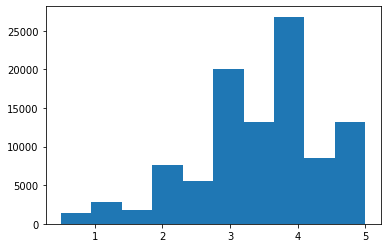

In [18]:
plt.hist(df.rating,10)

In [19]:
df["timestamp_float"] = df.timestamp.astype(np.float32)

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        8.5060e+03, 2.4076e+04, 2.4330e+04, 1.4418e+04, 2.9506e+04]),
 array([0.0000000e+00, 1.5377994e+08, 3.0755987e+08, 4.6133978e+08,
        6.1511974e+08, 7.6889965e+08, 9.2267955e+08, 1.0764595e+09,
        1.2302395e+09, 1.3840193e+09, 1.5377993e+09], dtype=float32),
 <BarContainer object of 10 artists>)

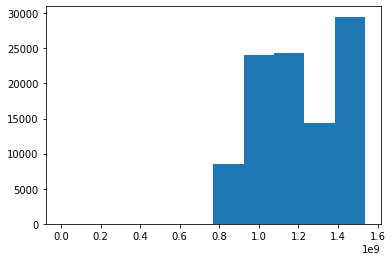

In [20]:
plt.hist(df.timestamp_float,10)

(array([ 108.,  185.,  309.,  694.,  962., 1840., 2211., 2275.,  798.,
         342.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <BarContainer object of 10 artists>)

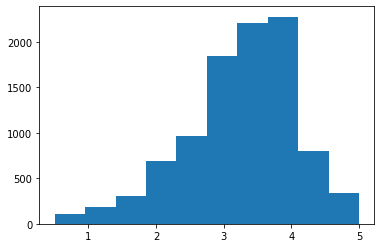

In [21]:
plt.hist(df.groupby(df.OID)["rating"].agg("mean"))

(array([  1.,   0.,   7.,  23.,  39., 148., 186., 154.,  45.,   8.]),
 array([1.275 , 1.6475, 2.02  , 2.3925, 2.765 , 3.1375, 3.51  , 3.8825,
        4.255 , 4.6275, 5.    ]),
 <BarContainer object of 10 artists>)

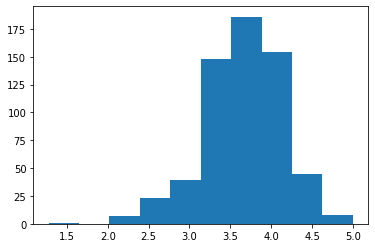

In [22]:
plt.hist(df.groupby(df.UID)["rating"].agg("mean"))

In [23]:

moviesDF.year.dtype

dtype('float64')

(array([3.000e+00, 2.400e+01, 1.020e+02, 2.260e+02, 3.040e+02, 4.810e+02,
        7.710e+02, 1.721e+03, 3.330e+03, 2.765e+03]),
 array([1902. , 1913.6, 1925.2, 1936.8, 1948.4, 1960. , 1971.6, 1983.2,
        1994.8, 2006.4, 2018. ]),
 <BarContainer object of 10 artists>)

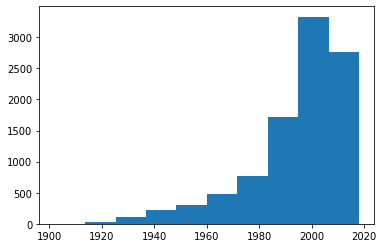

In [24]:
plt.hist(moviesDF.loc[moviesDF.year > 1900].year)